[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/obss/sahi/blob/main/demo/inference_for_huggingface.ipynb)

## 0. Preperation

- Install latest version of SAHI and Huggingface transformers:

In [14]:
!pip install -U git+https://github.com/obss/sahi.git
!pip install transformers timm

In [1]:
import os
os.getcwd()

'/home/devrim/lab/gh/sahi/demo'

- Import required modules:

In [1]:
# import required functions, classes
from sahi.model import HuggingfaceDetectionModel
from sahi.predict import get_sliced_prediction, predict, get_prediction
from sahi.utils.file import download_from_url
from sahi.utils.cv import read_image
from IPython.display import Image

/home/devrim/anaconda3/envs/sahi/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
06/10/2022 13:30:43 - INFO - sahi.utils.import_utils -   PyTorch version 1.10.2 available.


You can see object detection models available at [HF model hub](https://huggingface.co/models?pipeline_tag=object-detection&sort=downloads).

In [2]:
# Select a model to use, we use a DETR model.
model_path = "facebook/detr-resnet-50"

# download test images into demo_data folder
download_from_url('https://raw.githubusercontent.com/obss/sahi/main/demo/demo_data/small-vehicles1.jpeg', 'demo_data/small-vehicles1.jpeg')
download_from_url('https://raw.githubusercontent.com/obss/sahi/main/demo/demo_data/terrain2.png', 'demo_data/terrain2.png')

## 1. Standard Inference with a Huggingface Model

- Instantiate a detection model by defining model weight path, confing path and other parameters:

In [3]:
detection_model = HuggingfaceDetectionModel(
    model_path=model_path,
    config_path=model_path,
    confidence_threshold=0.5,
#     image_size=640,
    device="cpu", # or 'cuda'
)

06/10/2022 13:30:46 - INFO - timm.models.helpers -   Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)


- Perform prediction by feeding the get_prediction function with an image path and a DetectionModel instance:

In [4]:
result = get_prediction("demo_data/small-vehicles1.jpeg", detection_model)

- Or perform prediction by feeding the get_prediction function with a numpy image and a DetectionModel instance:

In [16]:
result = get_prediction(read_image("demo_data/small-vehicles1.jpeg"), detection_model)

- Visualize predicted bounding boxes and masks over the original image:

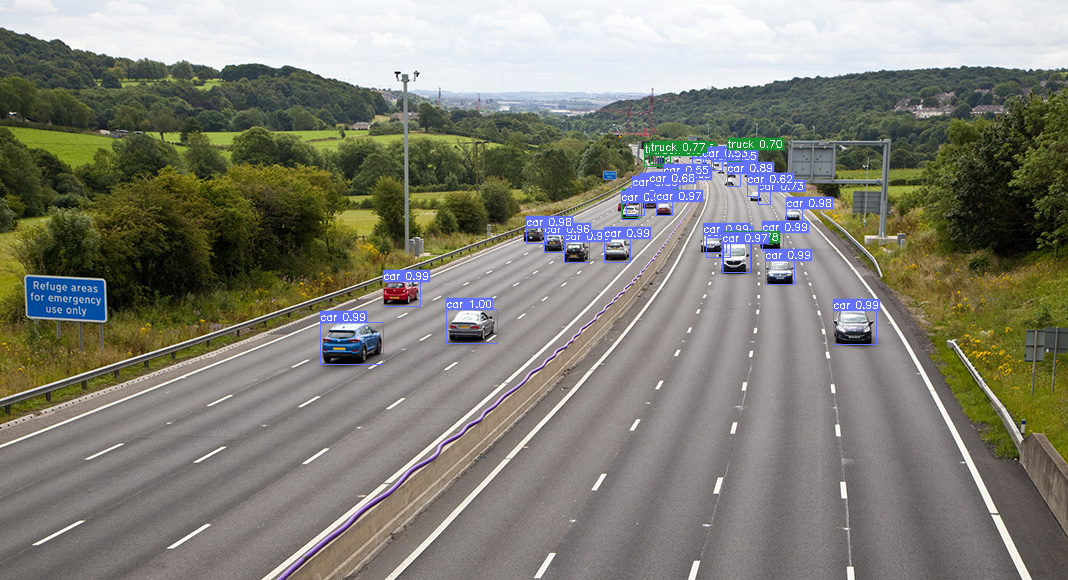

In [5]:
result.export_visuals(export_dir="demo_data/")

Image("demo_data/prediction_visual.png")

## 2. Sliced Inference with a Huggingface Model

- To perform sliced prediction we need to specify slice parameters. In this example we will perform prediction over slices of 512x512 with an overlap ratio of 0.2:

In [12]:
result = get_sliced_prediction(
    "demo_data/small-vehicles1.jpeg",
    detection_model,
    slice_height = 512,
    slice_width = 512,
    overlap_height_ratio = 0.2,
    overlap_width_ratio = 0.2,
)

Performing prediction on 6 number of slices.


- Visualize predicted bounding boxes and masks over the original image:

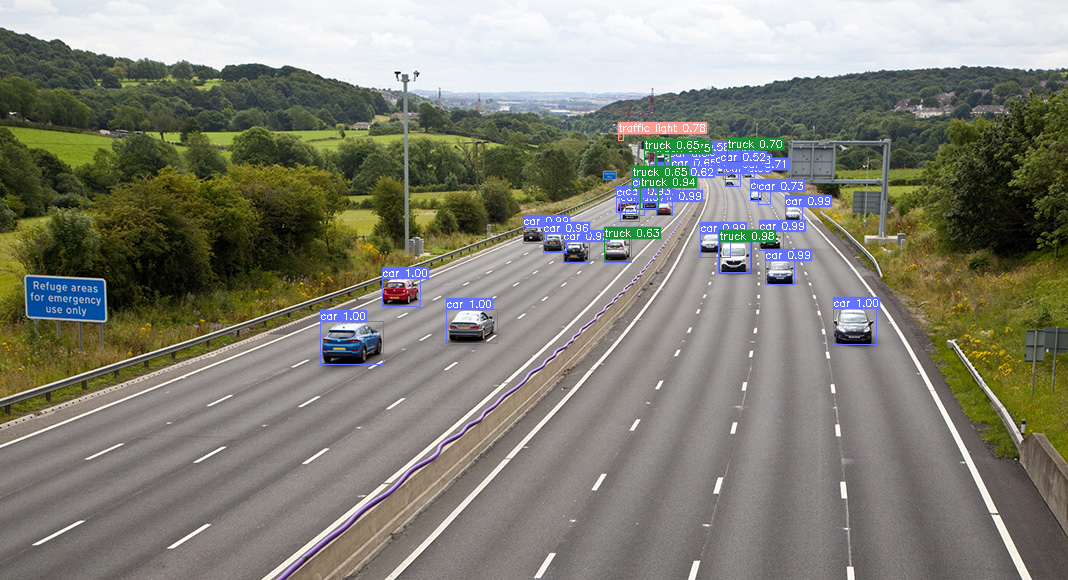

In [13]:
result.export_visuals(export_dir="demo_data/")

Image("demo_data/prediction_visual.png")

## 3. Prediction Result

- Predictions are returned as [sahi.prediction.PredictionResult](sahi/prediction.py), you can access the object prediction list as:

In [12]:
object_prediction_list = result.object_prediction_list

In [13]:
object_prediction_list[0]

ObjectPrediction<
    bbox: BoundingBox: <(446, 309, 497, 343), w: 51, h: 34>,
    mask: None,
    score: PredictionScore: <value: 0.9984517097473145>,
    category: Category: <id: 3, name: car>>

In [14]:
result.to_coco_annotations()[:3]

[{'image_id': None,
  'bbox': [446, 309, 51, 34],
  'score': tensor(0.9985),
  'category_id': 3,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 1734},
 {'image_id': None,
  'bbox': [320, 319, 63, 45],
  'score': tensor(0.9980),
  'category_id': 3,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 2835},
 {'image_id': None,
  'bbox': [833, 309, 43, 35],
  'score': tensor(0.9963),
  'category_id': 3,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 1505}]

- ObjectPrediction's can be converted to [COCO prediction](https://github.com/i008/COCO-dataset-explorer) format:

In [15]:
result.to_coco_predictions(image_id=1)[:3]

[{'image_id': 1,
  'bbox': [446, 309, 51, 34],
  'score': tensor(0.9985),
  'category_id': 3,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 1734},
 {'image_id': 1,
  'bbox': [320, 319, 63, 45],
  'score': tensor(0.9980),
  'category_id': 3,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 2835},
 {'image_id': 1,
  'bbox': [833, 309, 43, 35],
  'score': tensor(0.9963),
  'category_id': 3,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 1505}]

- ObjectPrediction's can be converted to [imantics](https://github.com/jsbroks/imantics) annotation format:

In [ ]:
!pip install -U imantics

In [11]:
result.to_imantics_annotations()[:3]

## 4. Batch Prediction

- Set model and directory parameters:

In [16]:
model_type = "huggingface"
model_path = model_path
model_config_path = model_path
model_device = "cpu" # or 'cuda:0'
model_confidence_threshold = 0.5

slice_height = 256
slice_width = 256
overlap_height_ratio = 0.2
overlap_width_ratio = 0.2

source_image_dir = "demo_data/"

- Perform sliced inference on given folder:

In [17]:
predict(
    model_type=model_type,
    model_path=model_path,
    model_config_path=model_path,
    model_device=model_device,
    model_confidence_threshold=model_confidence_threshold,
    source=source_image_dir,
    slice_height=slice_height,
    slice_width=slice_width,
    overlap_height_ratio=overlap_height_ratio,
    overlap_width_ratio=overlap_width_ratio,
)

There are 3 listed files in folder: demo_data/


06/08/2022 15:28:09 - INFO - timm.models.helpers -   Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth)
Performing inference on images:   0%|                     | 0/3 [00:00<?, ?it/s]

Performing prediction on 15 number of slices.


Performing inference on images:  33%|████▎        | 1/3 [00:13<00:27, 13.63s/it]

Prediction time is: 13577.86 ms
Performing prediction on 15 number of slices.


Performing inference on images:  67%|████████▋    | 2/3 [00:27<00:13, 13.49s/it]

Prediction time is: 13333.72 ms
Performing prediction on 20 number of slices.


Performing inference on images: 100%|█████████████| 3/3 [00:46<00:00, 15.44s/it]

Prediction time is: 19231.77 ms
Prediction results are successfully exported to runs/predict/exp2
